# Convert to isoparametric coordinate
2021.04.23 Kurama Okubo

2022.11.08 update for new balldrop test; update distance on isoparametric coordinate with the height of AE sensor.

2024.07.17 update to increase the pretrigger length

The event location $(\xi, \eta)$ and station $(x_s, y_s= \pm W/2)$ on the global coordinate is converted on the sensor-local coordinate $\boldsymbol{\xi}'$ as:

$$
 \boldsymbol{\xi}' = \begin{cases}
   [ -x_s +\xi, \eta - \dfrac{W}{2}], ~~ y_s \geq 0 \\
   [ x_s - \xi, -(\eta + \dfrac{W}{2})], ~~ y_s < 0
  \end{cases}
$$

<img src="./Isoparametric_coordinate_noedge_AEevent.png" alt="isoparacoord" width="400"/>


## Parameters

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib.patches import Rectangle, Circle, Ellipse

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["savefig.transparent"] = False
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime    
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
figdir = "../figure/debug_p03_isocoord"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [10]:
# Path for event location table
rootdir = "../../SensorCoupling_BallDrop/code/"

eventloc_table = rootdir+"../data/balldrop_locations.csv"

# Directory for picked waveforms
datadir = rootdir+"../data/DATA_computeCF"

# Data outputdir
outdir = "../data/DATA_isocoord" # make observation traces with the increased pretrigger

# channel table
channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'


In [11]:
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [12]:
df_eventloc = pd.read_csv(eventloc_table, index_col=0)

## Read channel array

In [13]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
channel_loc

{'OL01': [190.0, 50.0, 70.0],
 'OL02': [410.0, 50.0, 70.0],
 'OL03': [640.0, 50.0, 70.0],
 'OL04': [910.0, 50.0, 70.0],
 'OL05': [1160.0, 50.0, 70.0],
 'OL06': [1370.0, 50.0, 70.0],
 'OL07': [1660.0, 50.0, 70.0],
 'OL08': [1910.0, 50.0, 70.0],
 'OL09': [2160.0, 50.0, 70.0],
 'OL10': [2410.0, 50.0, 70.0],
 'OL11': [2650.0, 50.0, 70.0],
 'OL12': [2910.0, 50.0, 70.0],
 'OL13': [3160.0, 50.0, 70.0],
 'OL14': [3410.0, 50.0, 70.0],
 'OL15': [3660.0, 50.0, 70.0],
 'OL16': [3910.0, 50.0, 70.0],
 'OL17': [285.0, -50.0, 70.0],
 'OL18': [535.0, -50.0, 70.0],
 'OL19': [785.0, -50.0, 70.0],
 'OL20': [1035.0, -50.0, 70.0],
 'OL21': [1285.0, -50.0, 70.0],
 'OL22': [1535.0, -50.0, 70.0],
 'OL23': [1785.0, -50.0, 70.0],
 'OL24': [2035.0, -50.0, 70.0],
 'OL25': [2285.0, -50.0, 70.0],
 'OL26': [2535.0, -50.0, 70.0],
 'OL27': [2785.0, -50.0, 70.0],
 'OL28': [3035.0, -50.0, 70.0],
 'OL29': [3285.0, -50.0, 70.0],
 'OL30': [3535.0, -50.0, 70.0],
 'OL31': [3785.0, -50.0, 70.0],
 'OL32': [4035.0, -50.0, 70.0]}

## Search events close to AE sensor

In [14]:
df_iso_all = pd.DataFrame(columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'dist', 'xi1', 'eta1', 'zeta1'])

AEsensors = list(channel_loc.keys())
max_dist = 400 # [mm]
W = 100; #[mm]

for stnm in AEsensors:
    df_iso = pd.DataFrame(columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'dist', 'xi1', 'eta1', 'zeta1'])

    # stnm = AEsensors[8]
    station_loc = channel_loc[stnm]
    xs, ys, zs = station_loc
    eventind = []

    # find events within max_dist
    for index, row in df_eventloc.iterrows():
        source_loc = np.array([row['X'], row['Y'], row['Z']])*1e3 #[mm]
        dist = np.linalg.norm(source_loc-station_loc)
        if dist <= max_dist:
            eventind.append(index)

    # Shift coordinates
    for eid in eventind:
        datacase, xi, eta, zeta, Er = df_eventloc.loc[eid].values
        if ys >= 0:
            # OL01-16
            xi1, eta1, zeta1 = [-xs/1e3 + xi, eta-W/2/1e3, 0] #[m]
            dist1 = np.linalg.norm([xi1, eta1, zeta1-(zs*1e-3)]) # correct the distance: 2022.11.08 

        elif ys < 0:
            # OL17-32
            xi1, eta1, zeta1 = [xs/1e3 - xi, -(eta + W/2/1e3), 0] #[m]
            dist1 = np.linalg.norm([xi1, eta1, zeta1-(zs*1e-3)])

        
        iso_tmp = pd.DataFrame([[stnm, datacase, xs/1e3, ys/1e3, zs/1e3, np.round(xi, 5), np.round(eta, 5), zeta, dist1, np.round(xi1, 5), np.round(eta1, 5), zeta1]],
                                           columns=['OL', 'datacase', 'xs', 'ys', 'zs', 'xi', 'eta', 'zeta', 'dist', 'xi1', 'eta1', 'zeta1'],
                                           index=["{}__{}".format(stnm, datacase)])
        if not df_iso.empty:
            df_iso = pd.concat([df_iso, iso_tmp])
        else:
            df_iso = iso_tmp


    # check location 
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    left = 0 #[mm]
    bottom = -50 #[mm]
    width = 4100 #[mm]
    height = 100 #[mm]
    aspect_ratio = 3 # aspect ratio of rectangular plot
    fontsize=12

    rect = Rectangle((left, bottom), width, height, fill=True, color='white')

    ax.add_patch(rect)

    # plot isoparametric source location
    for index, row in df_iso.iterrows():
        xi1   = row["xi1"]*1e3 #[mm]
        eta1  = row["eta1"]*1e3 #[mm]
        zeta1 = row["zeta1"]*1e3 #[mm]
        # plot best location
        ax.plot(xi1, eta1, marker='o', markersize=12, markerfacecolor="y", markeredgecolor='k', markeredgewidth=1)

    # plot location of stations
    df_st = df_iso[df_iso.OL == stnm]
    xs, ys = np.unique([df_st['xs'], df_st['ys']])
    ax.plot(0, -3, marker='v', markersize=12, color='c', mec='k')

    ax.set_xlim(-max_dist, max_dist)
    ax.set_ylim(-W, 0)
    ax.set_aspect(aspect_ratio)
#     ax.set_xlabel(r"$\xi$' [mm]", fontsize=fontsize)
#     ax.set_ylabel(r"$\eta$' [mm]", fontsize=fontsize)
    ax.set_xlabel(r"x' [mm]", fontsize=fontsize)
    ax.set_ylabel(r"y' [mm]", fontsize=fontsize)
    ax.invert_yaxis()
    
    if not os.path.exists(figdir+"/isoloc"):
        os.makedirs(figdir+"/isoloc")
        
    plt.savefig(figdir+"/isoloc/balldrop_isoloc_{}.png".format(stnm), format="png", dpi=150)

    if not df_iso_all.empty:
        df_iso_all = pd.concat([df_iso_all, df_iso])
    else:
        df_iso_all = df_iso
        
    plt.clf()
    plt.close()

In [15]:
datacase

'BD_3940'

In [16]:
df_iso_all.to_csv("../data/balldrop_events_isocoord.csv")
df_iso_all

,OL,datacase,xs,ys,zs,xi,eta,zeta,dist,xi1,eta1,zeta1
OL01__BD_0220,OL01,BD_0220,0.190,0.05,0.07,0.217,-0.006,0.0,0.093622,0.027,-0.056,0
OL01__BD_0340,OL01,BD_0340,0.190,0.05,0.07,0.339,0.001,0.0,0.171761,0.149,-0.049,0
OL01__BD_0460,OL01,BD_0460,0.190,0.05,0.07,0.458,0.001,0.0,0.281292,0.268,-0.049,0
OL01__BD_0580,OL01,BD_0580,0.190,0.05,0.07,0.578,0.004,0.0,0.396938,0.388,-0.046,0
OL02__BD_0220,OL02,BD_0220,0.410,0.05,0.07,0.217,-0.006,0.0,0.212803,-0.193,-0.056,0
...,...,...,...,...,...,...,...,...,...,...,...,...
OL31__BD_3820,OL31,BD_3820,3.785,-0.05,0.07,3.821,0.007,0.0,0.097185,-0.036,-0.057,0
OL31__BD_3940,OL31,BD_3940,3.785,-0.05,0.07,3.941,0.001,0.0,0.178429,-0.156,-0.051,0
OL32__BD_3700,OL32,BD_3700,4.035,-0.05,0.07,3.699,0.002,0.0,0.347131,0.336,-0.052,0
OL32__BD_3820,OL32,BD_3820,4.035,-0.05,0.07,3.821,0.007,0.0,0.232261,0.214,-0.057,0


## Load waveform and save to pickle

In [17]:
pretrigger =  0.05 #0.0 #[ms]
windowlen = 0.4 #[ms]

AEsensors = list(channel_loc.keys())

# stnm = AEsensors[10]
for stnm in AEsensors:
    print("Start processing {}".format(stnm))

    # select events associated with single station
    df_iso_st = df_iso_all[df_iso_all.OL==stnm]

    # dataind = df_iso_st.index[1]
    for dataind in df_iso_st.index:

        foname = outdir+"/obs_isocoord_{}.pickle".format(dataind)

        if os.path.exists(foname):
            print("{} exist: skipping.".format(foname.split('/')[-1]))
#             continue
            
        print(dataind)
        dist = df_iso_all[df_iso_all.index == dataind]["dist"].values[0]*1e3
        xi1   = df_iso_all[df_iso_all.index == dataind]["xi1"].values[0]
        eta1  = df_iso_all[df_iso_all.index == dataind]["eta1"].values[0]
        zeta1 = df_iso_all[df_iso_all.index == dataind]["zeta1"].values[0]

        OL, datacase = dataind.split('__')

        # read data
        finame = datadir+"/{}.pickle".format(datacase)
        st = read(finame)

        st_OL = st.select(station="{}".format(OL))
        if st_OL.count() != 1:
            warn("multiple traces found on single station-event combination.")

        # select trace
        tr = st_OL[0].copy()

        tr.stats.origintime = st.origintime
        tr.stats.tpick = st.tpick[OL] - tr.stats.origintime 

        tr.stats.pretrigger = pretrigger #[ms]
        tr.stats.windowlen = windowlen #[ms]

        st0 = tr.stats.starttime
        pt = timedelta(milliseconds = tr.stats.pretrigger)
        wt = timedelta(milliseconds = tr.stats.windowlen)
        ot = timedelta(milliseconds = tr.stats.origintime)

        print(datacase, ot, pt)
        
        starttime = st0+ot-pt
        endtime = st0+ot+wt

        tr_trim = tr.copy() # avoid error in multiple trim
        tr_trim.trim(starttime, endtime, pad=True, fill_value=0.0)

        tr_trim.stats.starttime = st0

        # store stats
        tr_trim.stats.dist = dist
        tr_trim.stats.xi1 = xi1
        tr_trim.stats.eta1 = eta1
        tr_trim.stats.zeta1 = zeta1

        tr_trim.write(foname, format="pickle")

        # plot check ot and pick time
        tvec = np.array(range(0, tr_trim.stats.npts))*tr_trim.stats.delta*1e3 - tr_trim.stats.pretrigger #[ms]
        tvec
        xlimit = [-1.5, 20.5]
        ylimit = [-1.0, 1.0]
        fig, ax = plt.subplots(1, 1, figsize=(8, 3))
        ax.plot(tvec, tr_trim.data, 'k-')
        ax.axvline(tr_trim.stats.tpick, c = 'b', ls = '--')
#         ax.set_xlim(xlimit)
#         ax.set_ylim(ylimit)

        ax.set_xlabel("Time [ms]", fontsize=fontsize)
        ax.set_ylabel("Amplitude [V]", fontsize=fontsize)
        ax.set_title("{} Dist={:.2f} mm".format(dataind, dist), fontsize=fontsize)

        if not os.path.exists(figdir+"/trim_isocoord_waveform"):
            os.makedirs(figdir+"/trim_isocoord_waveform")

        plt.savefig(figdir+"/trim_isocoord_waveform/trim_isocoord_{}.png".format(dataind), format="png", dpi=150)

        plt.clf()
        plt.close()

Start processing OL01
OL01__BD_0220
BD_0220 0:00:00.000086 0:00:00.000050
OL01__BD_0340
BD_0340 0:00:00.000085 0:00:00.000050
OL01__BD_0460
BD_0460 0:00:00.000085 0:00:00.000050
OL01__BD_0580
BD_0580 0:00:00.000086 0:00:00.000050
Start processing OL02
OL02__BD_0220
BD_0220 0:00:00.000086 0:00:00.000050
OL02__BD_0340
BD_0340 0:00:00.000085 0:00:00.000050
OL02__BD_0460
BD_0460 0:00:00.000085 0:00:00.000050
OL02__BD_0580
BD_0580 0:00:00.000086 0:00:00.000050
OL02__BD_0700
BD_0700 0:00:00.000084 0:00:00.000050
Start processing OL03
OL03__BD_0340
BD_0340 0:00:00.000085 0:00:00.000050
OL03__BD_0460
BD_0460 0:00:00.000085 0:00:00.000050
OL03__BD_0580
BD_0580 0:00:00.000086 0:00:00.000050
OL03__BD_0700
BD_0700 0:00:00.000084 0:00:00.000050
OL03__BD_0820
BD_0820 0:00:00.000087 0:00:00.000050
OL03__BD_0940
BD_0940 0:00:00.000086 0:00:00.000050
Start processing OL04
OL04__BD_0580
BD_0580 0:00:00.000086 0:00:00.000050
OL04__BD_0700
BD_0700 0:00:00.000084 0:00:00.000050
OL04__BD_0820
BD_0820 0:00:0

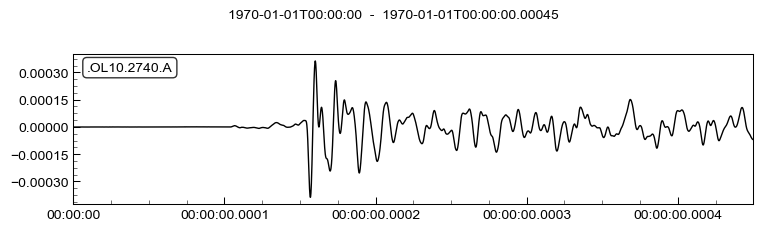

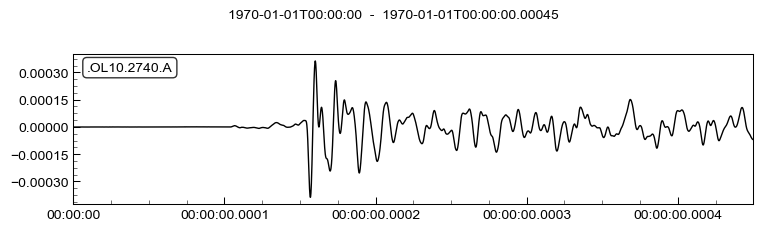

In [18]:
tr1 = read(outdir+"/obs_isocoord_OL10__BD_2740.pickle")[0]
tr1.stats
tr1.plot()

## Plot events associated with single station 

In [19]:
vmean = 6200

for stnm in AEsensors:
    df_iso_st = df_iso_all[df_iso_all.OL==stnm]
    xlimit = [0.0, 0.4]
    ylimit = [-1.2, 1.2]
    fig, axs = plt.subplots(len(df_iso_st), 1, figsize=(12, 12), sharex=True)

    for i, dataind in enumerate(df_iso_st.index):

        OL, datacase = dataind.split('__')
        # read trace
        tr_trim = read(outdir+"/obs_isocoord_{}.pickle".format(dataind))[0]

        tvec = np.array(range(0, tr_trim.stats.npts))*tr_trim.stats.delta*1e3 - tr_trim.stats.pretrigger #[ms]
        axs[i].plot(tvec, tr_trim.data*1e3, 'k-')
        axs[i].axvline(tr_trim.stats.tpick, c = 'b', ls = '--')
        # pick time from theoretical arrival
        axs[i].axvline(tr_trim.stats.dist/vmean, c = 'r', ls = '--')
        axs[i].set_xlim(xlimit)
        axs[i].set_ylim(ylimit)
        if i == len(df_iso_st)-1:
            axs[i].set_xlabel("Time [ms]", fontsize=fontsize)

        axs[i].set_ylabel("Velocity [mm/s]", fontsize=fontsize)
        axs[i].set_title("{} Dist={:.2f} mm".format(dataind, tr_trim.stats.dist), fontsize=fontsize)
        axs[i].tick_params(direction='in')

    fig.tight_layout()
    if not os.path.exists(figdir+"/events_on_single"):
        os.makedirs(figdir+"/events_on_single")

    plt.savefig(figdir+"/events_on_single/events_on_single_{}.png".format(stnm), format="png", dpi=150)

    plt.clf()
    plt.close()

## Save green's function location file for OpenSWPC modeling

In [20]:
# df_iso_all = pd.read_csv("../data/balldrop_events_isocoord.csv",  index_col=[0])

# fo = open("../data/green_in_balldrop.txt", "w")
# fo.write("# balldrop event loc for green's function\n#     x     y    z    gid\n# --------------------------------------------------------------------------------------------\n")
# for index, row in df_iso_all.iterrows():
#     xi1, eta1, zeta1, gid = [row["xi1"], row["eta1"], row["zeta1"], index]
#     fo.write("{:.8e} {:.8e} {:.8e} {}\n".format(xi1/1e3, eta1/1e3, zeta1/1e3, gid)) # locations are in [km]
    
# fo.close()

In [21]:
# save green txt for side coordinate
df_iso_all = pd.read_csv("../data/balldrop_events_isocoord.csv",  index_col=[0])

dy = 1.0e-6

fo = open("../data/green_in_balldrop_sidecoord.txt", "w")
fo.write("# balldrop event loc for green's function\n#     x     y    z    gid\n# --------------------------------------------------------------------------------------------\n")
gindex = 0
gindex_dict = {}
for index, row in df_iso_all.iterrows():
    xi1, eta1, zeta1, gid = [row["xi1"], row["eta1"], row["zeta1"], index]
    fo.write("{:.8e} {:.8e} {:.8e} {}\n".format(xi1/1e3, zeta1/1e3+dy, -eta1/1e3, gindex)) # locations are in [km]
    gindex_dict[index] = gindex
    gindex = gindex+1
    
fo.close()

In [22]:
# save green function index table
df_gindex = pd.DataFrame(gindex_dict.items(), columns=['index', 'gid'])
df_gindex.to_csv("../data/gindex_table.csv")

NOTE: the arrival time is modified from the preliminary result due to the removal of instremental response.